# COGS 189: EEG-Based Brain Computer Interfaces
## Assignment 1: Intro to EEG Pre-Processing
Created By: Alessandro "Ollie" D'Amico
***
**Due: Jan 23**
***
## Overview:
For this assignment, we will be going over the basics of EEG processing and filtering. The dataset we will be working with is synthetic and was generated to easily visualize differences between target and non-target stimuli which have been corrupted with noise.<br>
***
### EEG Data:
For this dataset, we will be analyzing synthetic data which aims to mimic an exagorated P300-like response. In assignment 2 you will analyze actual P300 speller data!
<br><br>
The EEG data collected was sampled at 500 Hz. For those unfamiliar: <br>
\begin{equation*}
Hz = 
\frac{1}{second}
\end{equation*}
<br>
Which means we collect 500 points of data per second at a data collection rate of 500 Hz.
<br>
This is referred to as the **sampling rate**, and is often denoted as \begin{equation*}
F_s \end{equation*} *Fs* or *fs* is commonly used when writing code.
***
***Question 1:*** How many milliseconds (ms) are there between each data point when the sampling rate is 200 Hz? 
<br>*(Hint: At 1000 Hz, there is 1ms between each data point. At 250 Hz, there is 4ms between each data point.)*<br>
***
## Section 1: Setup
Before we can begin processing our data, we must first import some useful packages. <br>
- **numpy** is used widely for processing numerical data, and supports matrix operations natively. We will be using NumPy arrays to store our data.
- **scipy** contains useful functions to calculate filter coefficients and carry out filtering. We will be using SciPy filters to clean our EEG data.
- **matplotlib** is used to create plots. We will use it to visually explore our filter and EEG data.

For those unfamiliar with Jupyter, you must click on the block of code you wish to run, and click the ***Run*** button in the upper toolbox.

In [15]:
hz = 200;
period = 1/hz;
print(f"{period} s")
print(f"{period * 1000} ms")

0.005 s
5.0 ms


In [5]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting

We'll now define some functions for filtering. The specifics of the filters will be explained in the next section. The code used for these functions was taken and subsequently adapted from:
https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [6]:
# Credit for these functions goes to 'WarrenWeckesser'
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

## Section 2: Filter Design
For EEG data analysis, there are various decisions that need to be made when selecting an appropriate filter. All signals are corrupted by outside noise, and EEG data is particularly susceptible to noise from electronics, muscle movements, and skin conductance changes (sweat). Filtering allows us to get rid of some of the junk, but it is not magic. There is no substitute for collecting clean data. Filtering will also throw out some of the data we care about, but this is a relatively small price to pay. <br><br>
When selecting a filter, it is often a good idea to review the relevant literature. <br><br>
For this assignment, we will be using a common filter for ERP research known as the Butterworth filter (IIR). Butterworth filters aim to remove (attenuate) frequencies which you are not interested in, while leaving the frequencies you are interested in alone. We will be constructing a Butterworth *bandpass* filter. Bandpass filters allow a certain range (*band*) of frequencies to *pass* through, while other frequencies are attenuated (the opposite of amplified). <br><br>
The specifics of filter construction are beyond the scope of this class, but the current filter is designed for offline use. We will show an example of a filter that can be used an in online system in assignment 2.<br><br>
We must define the sampling rate, along with the lower and upper thresholds of frequencies to pass, and an order for our filter. We will be choosing **0.1 Hz** as our lowest frequency to pass, and **10 Hz** as our highest frequency to pass. We will investigate the effects of order in this assignment.

In [7]:
# Create filtering variables
fs = 500.0     # 500 Hz sampling rate
lowcut = 0.1   # 0.1 Hz is the lowest frequency we will pass
highcut = 10.0 # 10  Hz is the highest frequency we will pass.

Next we will investigate the effect order has on the Butterworth filter. Ideally, we would keep the frequencies between 0.1-10 Hz alone while setting everything else to 0. Here is an idealized filter:
***
***Question 2:*** Modify the temporary variables ```low_cut_temp``` and ```high_cut_temp``` in the next block of code so that the filter passes frequencies between 20 Hz and 40 Hz. Take a snapshot of the resulting plot as your answer to this question.
***

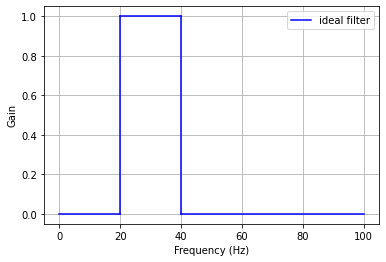

In [9]:
# -- Question 2 --
low_cut_temp  = 20.0; # EDIT THIS VARIABLE
high_cut_temp = 40.0; # EDIT THIS VARIABLE

# Plot an ideal filter 
plt.figure(0);
plt.clf();

# Draw out an ideal boxcar filter (you can ignore all of this code, just run it)
plt.plot([0.0,     low_cut_temp],  [0, 0], 'b-')
plt.plot([low_cut_temp,  low_cut_temp],  [0, 1], 'b-')
plt.plot([low_cut_temp,  high_cut_temp], [1, 1], 'b-')
plt.plot([high_cut_temp, high_cut_temp], [1, 0], 'b-')
plt.plot([high_cut_temp, 100.0],   [0, 0], 'b-', label="ideal filter")
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.legend(loc = 'best')

plt.show();

In this plot, the x-axis represents the frequencies in the signal and the y-axis is the gain of the filter. A gain of 1 means that signals of that frequency are passed at the same magnitude. A gain of 0 means signals at those frequencies are completely attenuated.
<br><br>
However, this idealized filter has several drawbacks and is not achievable in the real world. Data which pass through this filter may have their phase
heavily distorted. There is a tradeoff between how sharply you can dissect signals in time and frequency. If you make sharp
changes in frequency you will distort the time-domain waveform and vice-versa.In order to get the benefit of this 'brickwall' design, the Butterworth filter 'rounds' the corners, which ameliorates these distortions. 
<br><br>
In the Butterworth filter, the 'sharpness' of the corners is determine by the order of the filter. Higher orders approach an idealized filter. Let's explore this concept by plotting increasing orders of Butterworth filters below.
***
***Question 3:*** Modify the ```orders``` variable to include values 8, 10, and 60 (i.e. 6 total values). Run the code, and take a snapshot of the plot as the answer to this question.
***

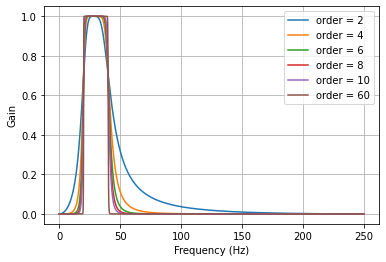

In [11]:
# Explore the effects of order on the Butterworth filter
# This code was adapted from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
plt.figure(1)
plt.clf()

orders = [2, 4, 6, 8, 10, 60]; # -- Question 3 --

for order in orders:
    sos = butter_bandpass(low_cut_temp, high_cut_temp, fs, order = order)
    w, h = sosfreqz(sos, worN = 2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label = f"order = {order}")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc = 'best')

plt.show();

***
***Question 4:*** Besides the corners becoming sharper, what is an observable effect of increasing the order?
***
## Section 3: EEG Data
We will now load in and process the EEG data. There are several aspects to pre-processing which we will cover:
- Filtering
- Epoching
- **Grouping**
- Baseline correcting
- Averaging

***Note: In machine learning the term 'binning' can be defined as taking the average of data points around each other. In ERP research, 'binning' may also refer to grouping certain trials together based on their category. In order to avoid confusion, in this assignment we will be using the term grouping to refer to combining like-data together*** 

We will examine the data at each of these stages so that the effects of each step becomes intuitive. First, let's load in the data. The data are broken up into 3 parts:
- **raw_eeg_df** contains our continous synthetic EEG data
- **time_df** contains the time points (in seconds)
- **mark_df** contains our markers and when they occurred

In [12]:
# Load all of our datasets                           
raw_eeg_df  = np.genfromtxt('Data_noisy_df.csv', delimiter=','); # Continuous EEG data (uV)
time_df     = np.genfromtxt('Time_df.csv', delimiter=',');       # Time points (sec) of each sample above
mark_df     = np.genfromtxt('Markers_df.csv', delimiter=',');    # Markers and when they occurred in time (sec)

Let's examine some of the basic properties of our dataset. ```raw_eeg_df``` should have the same dimensions as ```time_df``` since we only have a single channel of data. We can explore this by looking at the shape of the arrays. We will also plot our continuous data to build some intuition of how much time our data span

(43303,)
(43303,)


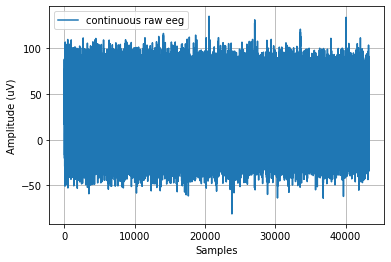

In [13]:
# Explore the shape of our data
print(raw_eeg_df.shape)
print(time_df.shape)

# Plot the continuous data
plt.plot(raw_eeg_df[:], label = "continuous raw eeg");
plt.xlabel('Samples');
plt.ylabel('Amplitude (uV)');
plt.grid(True);
plt.legend(loc = 'best');

***
***Question 5:*** How much time is contained in this continuous dataset? *(Hint: Use your answer from Question 1 and the shape of time_df)*
***

In [27]:
time = 1/fs * 1000 * time_df.shape[0]
print(time)

86606.0


Now we will examine ```mark_df```, which has 2 columns. The first contains information about which stimulus the participant (or in this case a simulation) saw.
- **0** indicates the stimulus was a target (the infrequent or oddball stimulus)
- **1** indicates the stimulus was a non-target (the frequent stimulus)


The second column contains the precise time the stimulus was shown. Let's take a look at the first six data points:

In [29]:
np.set_printoptions(suppress = True) # To not have scientific notation
mark_df[0:6, :]

array([[   0.        , 8112.98985055],
       [   1.        , 8119.48984392],
       [   0.        , 8125.98984729],
       [   1.        , 8132.48984425],
       [   0.        , 8138.98984912],
       [   1.        , 8145.48984799]])

***
***Question 6:*** How many trials (i.e. number of markers) do we have? <br>
***Question 7:*** How many target trials do we have?
***

In [23]:
# -- Question 6 --
print(mark_df.shape[0])

# -- Question 7 --
target_code = 0;
print(np.count_nonzero(mark_df[:, 0] == target_code))

9
5


Let's begin our data exploration by examining the effect of filtering our data.<br>
Let's look at a random section of data:

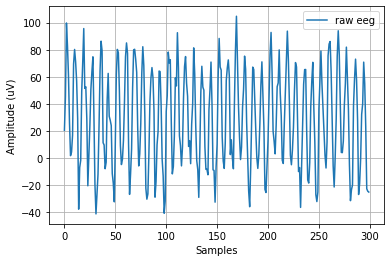

In [24]:
# Plot a random 300-sample chunk of data
plt.plot(raw_eeg_df[600:900], label = "raw eeg");
plt.xlabel('Samples');
plt.ylabel('Amplitude (uV)');
plt.grid(True);
plt.legend(loc = 'best');

As we can see, these data appear to be contaminated by high frequency noise. <br><br>

Let's now apply our Butterworth filter to the entirety of our ```raw_eeg_df``` and save it as ```clean_eeg_df```. <br><br>

As a reminder, we will be passing the following arguments into our function:
- **data:** our raw_eeg_df data
- **lowcut:** the lowest frequency we will allow (0.1 Hz)
- **highcut:** the highest frequency we will allow (10 Hz)
- **fs:** our sampling rate (500 Hz)
- **order:** the order of our filter

For this assignment, we will be defining ```order``` = 2. 2 is commonly used for P300 and other ERPs, so we will stick with it as the literature validates its selection. Note that since we are applying a non-causal filter, the effective filter order is actually doubled since the filter is being applied twice.

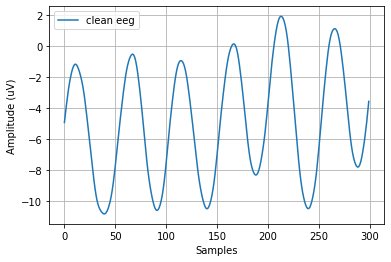

In [25]:
# Filter our raw_eeg_df
order = 2;
clean_eeg_df = butter_bandpass_filter(raw_eeg_df, lowcut, highcut, fs, order)

# And now let's plot the same 300-sample chunk
plt.plot(clean_eeg_df[600:900], label = "clean eeg");
plt.xlabel('Samples');
plt.ylabel('Amplitude (uV)');
plt.grid(True);
plt.legend(loc = 'best');

The data look considerably better, and that higher frequency noise has been heavily attenuated. Now that we have filtered all of our EEG data, we can begin to epoch the clean data!
<br><br>
Epoching is the step of pre-processing where we segment the data into the chunks we care about. We are only interested in the brief periods of time the participant has seen the stimulus. When epoching data, we must decide how much data is worth keeping. Since the P300 occurrs between 300-400ms after the onset of a stimulus, we know we need to go out atleast 300ms after our marker times. We also need to save some data before the onset of the stimulus so that we can perform *baseline correction*. <br><br>

Baseline correction involves selecting a period of time where there is little to no neuronal activity of interest occurring. We can take the average of this 'nothingness' period and subtract it from all samples in our epoch so that the baseline has zero mean. This is important because variability in the EEG data makes it so that each epoch has a slightly different average amplitude. Without baseline correction, the amplitudes of peaks being averaged may cause false positives during data analysis, which is something we obviously want to avoid. <br><br>

Since we want our baseline period to contain as few interesting signals as possible, we usually look a few hundred milliseconds before the onset of the stimulus. For this analysis, we will be using a 100ms chunk of data which starts 400ms before the onset of the stimulus as our baseline. We can therefore start our epoch 400ms before the onset of the stimulus.
<br><br>
For the last point of the epoch, we want to make sure we capture the entire ERP of interest. We could safely go to about 500ms after the onset of the stimulus for the P300. <br><br>

For the sake of clean plots, you will often see researchers slightly overshoot their epochs, and we will be doing the same. The starting time point will be 500ms before the onset of the stimulus, and the ending time point will be 1000ms after the onset of the stimulus. Let's define these variables, and create a new ```epoched_df``` to contain our epoched data.

In [30]:
# Define the bounds of our epoch as well as our baseline
epoch_s = -500; # 500ms before stimulus
epoch_e = 1000; # 1000ms after stimulus
bl_s    = -400; # 400ms before stimulus
bl_e    = -300; # 300ms before stimulus
dt      = (fs / 1000)

# Let's calculate the length our epoch with our given sampling rate
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * dt);

# And let's define our epoch_df to fit our needs. 
# Each row contains a unique epoch of data
epoch_df = np.zeros(shape = (int(mark_df.shape[0]), epoch_len));

# Let's print the shape of epoch_df so we can verify it's correct
print(epoch_df.shape)

(9, 750)


Now that we have created ```epoch_df```, we can begin epoching our dataset. We will do this by using the times in ```mark_df``` to select the appropriate chunk of data, which we will store in ```epoch_df```.

In [31]:
# Let's define some helpful variables to make our extraction easier
e_s = int(epoch_s * (fs / 1000)); # effectively the number of indices before marker we want
e_e = int(epoch_e * (fs / 1000)); # effectively the number of indices after marker we want

# Epoch the data
for i in range(0, int(mark_df.shape[0])):
    # check description below for calculation of t
    marker_time = mark_df[i, 1];
    t_ = np.where((time_df < (marker_time + dt/1000)) & (time_df > (marker_time - dt/1000)))[0]
    t  = t_[np.argmin(np.abs(marker_time - time_df[t_]))]
    epoch_df[i, :] = clean_eeg_df[t + e_s:t + e_e] # grab the appropriate samples around the stimulus onset

***
#### Epoching explanation
In the above section of code, the variable ```t``` is being calculated every iteration. Essentially, ```t``` is the location in index space which represents the time at which any given marker was presented. When we index ```mark_df```, we obtain a value in time, representing when the marker was presented in actual time, which we have stored in ```time_df```. However, if we check for where any given marker exists in ```time_df```, we will not obtain any matches:


In [32]:
# Part of explanation (not being graded on this)
marker_time = mark_df[0, 1]
print(marker_time)
print(np.where(time_df == marker_time)) # no matches!

8112.989850549563
(array([], dtype=int64),)


In the above sample, we obtained no results. This is because ```mark_df``` is being sampled at an irregular sampling rate and therefore the precise time a marker was sent is unlikely to align perfeclty with our EEG data which is regularly sampled at 500 Hz. In order to compensate for this, we can search for a time point within ```time_df``` that is very close to our marker. In the above example, we look for every time point which is within one ```dt``` larger and smaller than our marker (in this case we convert ```dt``` into seconds by dividing by 1000).
<br><br>
Using the above marker example, we receive the following time points:

In [33]:
time_df_locs = np.where((time_df < (marker_time + dt/1000)) & (time_df > (marker_time - dt/1000)))[0]
time_df_times = time_df[time_df_locs]
print(time_df_locs)
print(time_df_times)

[14051]
[8112.98980931]


We then subtract all of these time points from our marker and compute the absolute value so that we can find the one which is closest to our marker's time

In [34]:
min_time_ix = np.argmin(np.abs(marker_time - time_df_times))
print(min_time_ix)
print(time_df_times[min_time_ix])

0
8112.989809307597


Finally, we can index our original times locations to retrieve the best index

In [35]:
print(time_df_locs[min_time_ix])

14051


Now we can grab the samples around that time point and epoching is complete!
#### (epoching explanation done)
***

We will now baseline correct our epoched data.

In [36]:
# Create some helpful variables
b_s = int((abs(epoch_s) + bl_s) * (fs / 1000)); # index in epoch_df where our baseline begins
b_e = int((abs(epoch_s) + bl_e) * (fs / 1000)); # index in epoch_df where our baseline ends

# Perform baseline correction
for i in range(0, int(epoch_df.shape[0])):
    epoch_df[i, :] = epoch_df[i, :] - np.mean(epoch_df[i, b_s:b_e]);

We will now *group* our data. This means that we will segregate the non-target (1) and target (2) epochs by using ```mark_df```. We will create  ```norm_df``` which will contain our non-target eeg dat, and ```odd_df```, which will contain our target oddball data. The following method of grouping is only viable because the structure of ```mark_df``` and ```epoch_df``` are such that the rows correspond to one another. 

In [37]:
# Let's first grab which indices contain a 1 so that we can create our dataframes in one move
norm_ix = (np.isin(mark_df[:, 0], 1)); # creates a boolean matrix, returning true for non-target trials

# Now let's group our data
norm_df = epoch_df[ norm_ix, :]; # normal epochs contain a 1
odd_df  = epoch_df[~norm_ix, :]; # oddball epochs do not contain a 1

Let's now create an average waveform for ```norm_df``` and ```odd_df``` and plot our final waveforms!
<br><br>
We will be plotting positive up, although it's common to see negative plotted up as well.

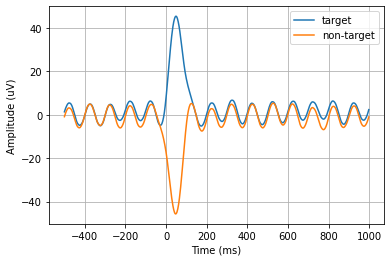

In [38]:
# Create our time points
dt = int(round(1 / (fs / 1000))); # note: this is the same as our 'rounder' variable from earlier
times = range(epoch_s, epoch_e, dt)

# Create our average waveforms
norm_ave = np.mean(norm_df, axis = 0);
odd_ave  = np.mean(odd_df,  axis = 0);

# Plot our waveforms
plt.plot(times, odd_ave, label =  "target");
plt.plot(times, norm_ave, label = "non-target");
plt.xlabel('Time (ms)');
plt.ylabel('Amplitude (uV)');
plt.grid(True);
plt.legend(loc = 'best');

***
***Question 8:*** Take a snapshot of this plot as the answer for this question
***